In [117]:
import torch
import spacy
import numpy as np
import torchtext.vocab
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchtext import data
import torch
import torch.nn as nn
from sentiment_model.data_utils.tweet_dataset import TweetDataset, pad_batch
from sentiment_model.evaluation import run_evaluation
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import os
from utils import get_project_root
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sentiment_model.model_calibration import plot_calib_curve, CalibratedModel
from time import time
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from torch.utils.data import Subset
from itertools import combinations, product
from sklearn.model_selection import KFold
from torch.utils.data import random_split

In [2]:
time1 = time()
preds, targets, model = run_evaluation(model_file="lemon-forest-81/lemon-forest-81-epoch-1.pth", num_classes=2,
                                dataset="sent140_multi_class")
time2 = time()

print(f"evaluation took {np.round(time2-time1, 2)} s")

# Import GloVe Embeddings
# Load training dataset to build vocab
cache_path = os.path.join(get_project_root(), Path("sentiment_model/.vector_cache/"))
glove_twitter = GloVe(name="twitter.27B", dim=50, cache=cache_path)

# Instantiate vectors and ensure a 0 vector is inserted for unknown characters and padded characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(2, pre_embeds.shape[1]), pre_embeds))

# Load data:
valid_dataset = TweetDataset(split="valid", dataset="sent140_multi_class", pretrained_vecs=glove_twitter)
valid_y = [y for _, y in valid_dataset]

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

evaluation took 10.82 s


Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
CM = CalibratedModel(model)

time1 = time()
preds = CM.fit(valid_dataset, valid_y, return_model_probs=True)
time2 = time()

print(f"Fitting took {np.round(time2-time1, 2)} s")

Fitting took 168.94 s


In [4]:
time1 = time()
pred_calib = CM.predict_proba(valid_dataset)
time2 = time()

print(f"Predicting calibrated probs took {np.round(time2-time1, 2)} s")

Predicting calibrated probs took 169.39 s


In [15]:
random_split(valid_dataset, [0.8, 0.2])

In [15]:
cv_split = KFold(shuffle=True, n_splits=5)
for  in cv_split.split(valid_dataset):
    print(split[0])
    valid_dataset[split[0]]

[     0      1      2 ... 319996 319997 319998]


TypeError: only integer scalar arrays can be converted to a scalar index

In [45]:
pred_calib#reshape(-1,1)

array([[0.49577271, 0.50422729],
       [0.92056369, 0.07943631],
       [0.42854554, 0.57145446],
       ...,
       [0.01359485, 0.98640515],
       [0.80556747, 0.19443253],
       [0.8100458 , 0.1899542 ]])

In [50]:
max_prob = np.argmax(pred_calib, axis=1)
#np.take_along_axis(pred_calib,max_prob.reshape(-1,1),axis=1)
max_prob[max_prob > 0] = 2
max_prob

array([2, 0, 2, ..., 2, 0, 0], dtype=int64)

In [148]:
type((1, 2)) == tuple

True

In [197]:
def one_hot_to_1d(arr):
    return np.argmax(arr, axis=1)

def one_hot_transform(labels_1d, unique_label_count="infer"):
    if unique_label_count == 'infer':
        unique_label_count = labels_1d.max()+1

    encoded = np.zeros((len(labels_1d), unique_label_count), dtype=int)
    encoded[np.arange(len(labels_1d)), labels_1d] = 1
    return encoded

def predict(clf, dataset, boundary):
    pred_probs = clf.predict_proba(dataset)

    if type(boundary) == tuple:
        return predict_flexible_boundary(pred_probs, boundary)

    else:
        return predict_boundary(pred_probs, boundary)

def predict_boundary(pred_probs, boundary):
    max_prob_idx = np.argmax(pred_probs, axis=1)
    max_probs = np.take_along_axis(pred_probs,max_prob_idx.reshape(-1,1),axis=1).reshape(-1)

    predictions = np.zeros(len(pred_probs), dtype=int)
    predictions[max_prob_idx > 0] = 2
    predictions[max_probs < boundary] = 1
    return predictions

def predict_flexible_boundary(pred_probs, boundary):
    b_0, b_2 = boundary
    pred_probs = np.insert(pred_probs, 1, np.zeros(len(pred_probs)), axis=1)
    # Set predicted probabilities to zero for non-maximal probs
    pred_probs[~(pred_probs == np.max(pred_probs, keepdims=True, axis=1))] = 0
    # Set predicted probabilities not reaching respective boundary to zero
    pred_probs[pred_probs[:, [0,1,2]] < np.array([b_0, 0, b_2])] = 0
    # Predicting neutral category where pos/neg not reached boundary
    pred_probs[(pred_probs == 0).all(axis=1), 1] = 1
    pred_probs[pred_probs > 0 ] = 1
    return one_hot_to_1d(pred_probs.astype(int))

def compute_decision_boundary(clf, dataset, boundaries, scorer=f1_score, scorer_args={"average":"macro"}, return_scores=False):
    pred_probs = clf.predict_proba(dataset)
    labels = [y for _,y in dataset]
    labels = one_hot_transform(np.array(labels))
    scores = []
    for b in boundaries:
        preds = predict_boundary(pred_probs,b)
        preds = one_hot_transform(preds, unique_label_count=labels.shape[1])
        #scores.append(roc_auc_score(labels, preds, multi_class="ovr"))
        scores.append(scorer(labels, preds, **scorer_args))
    if return_scores:
        return boundaries[np.argmax(scores)], scores
    else:
        return boundaries[np.argmax(scores)]

def compute_decision_boundary(clf, dataset, boundaries, scorer=f1_score, scorer_args={"average":"macro"}, return_scores=False, flexible=False):
    pred_probs = clf.predict_proba(dataset)
    labels = [y for _,y in dataset]
    labels = one_hot_transform(np.array(labels))
    scores = []
    for b in boundaries:
        #print(flexible)
        if flexible:
            preds = predict_flexible_boundary(pred_probs,b)

        else:
            preds = predict_boundary(pred_probs,b)

        preds = one_hot_transform(preds, unique_label_count=labels.shape[1])
        #scores.append(roc_auc_score(labels, preds, multi_class="ovr"))
        scores.append(scorer(labels, preds, **scorer_args))
    if return_scores:
        return boundaries[np.argmax(scores)], scores
    else:
        return boundaries[np.argmax(scores)]

def dec_bound_opt(clf, dataset, boundaries, flexible=False, scorer=f1_score, scorer_args={"average":"macro"}):
    cv_split = KFold(shuffle=True, n_splits=5)

    test_scores = []

    for train_split, test_split in cv_split.split(dataset):
        train, test = Subset(dataset, train_split), Subset(dataset, test_split)
        dec_bound = compute_decision_boundary(clf, train, boundaries, flexible=flexible, scorer=scorer, scorer_args=scorer_args)
        test_pred = predict(clf, test, dec_bound)
        test_true = [y for _,y in test]
        test_scores.append(scorer(test_true, test_pred, **scorer_args))

    return test_scores

In [7]:
test_dataset = TweetDataset(split="test", dataset="sent140_multi_class", pretrained_vecs=glove_twitter)


Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

In [223]:
np.unique(np.array(test_dataset.get_y()), return_counts=True)

(array([0, 1, 2]), array([177, 139, 182], dtype=int64))

In [216]:
cv_scores = dec_bound_opt(CM, test_dataset, scorer=f1_score, scorer_args={"average":"macro"}, boundaries=np.linspace(0.5, 1, 50), flexible=False)
print(f"CV Scores: {np.round(np.mean(cv_scores), 3)} +- {np.round(np.std(cv_scores), 3)}")

CV Scores: 0.538 +- 0.033


In [217]:
cv_scores = dec_bound_opt(CM, test_dataset, boundaries=list(product(np.linspace(0.5, 1, 25), np.linspace(0.5, 1, 25))), flexible=True, scorer=f1_score, scorer_args={"average":"macro"})
print(f"CV Scores: {np.round(np.mean(cv_scores), 3)} +- {np.round(np.std(cv_scores), 3)}")

CV Scores: 0.565 +- 0.053


In [201]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(1,1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    labels = ['negative', 'neutral', 'positive']
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

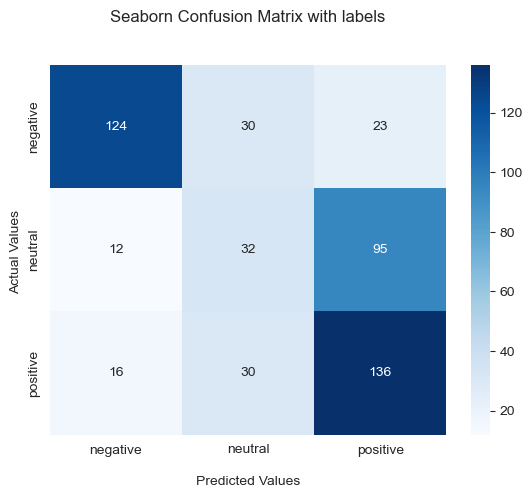

In [218]:
#compute_decision_boundary(CM, Subset(valid_dataset, range(100)), boundaries=np.linspace(0.5, 1, 50), return_scores=True)
dec_bound, scores = compute_decision_boundary(CM, test_dataset, scorer=f1_score, scorer_args={"average":"macro"}, boundaries=np.linspace(0.5, 1, 50), flexible=False, return_scores=True)
preds = predict(CM, test_dataset, dec_bound)
plot_confusion_matrix(confusion_matrix(test_dataset.get_y(), preds))

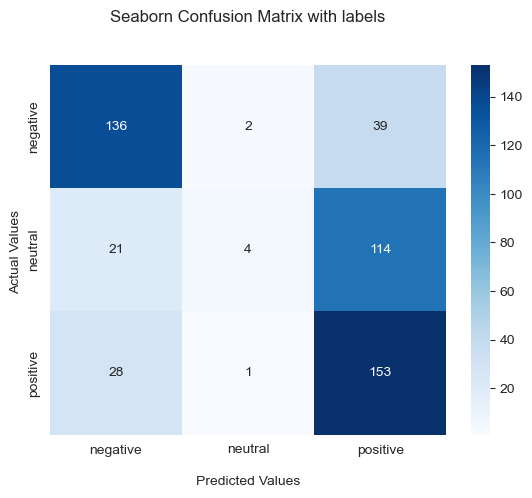

In [228]:
sample_weight = [3 if l!=1 else 1 for l in test_dataset.get_y()]
dec_bound, scores = compute_decision_boundary(CM, test_dataset, scorer=f1_score, scorer_args={"average":"micro", "sample_weight": sample_weight}, boundaries=list(product(np.linspace(0.5, 1, 25), np.linspace(0.5, 1, 25))), flexible=True, return_scores=True)
preds = predict(CM, test_dataset, dec_bound)
plot_confusion_matrix(confusion_matrix(test_dataset.get_y(), preds))

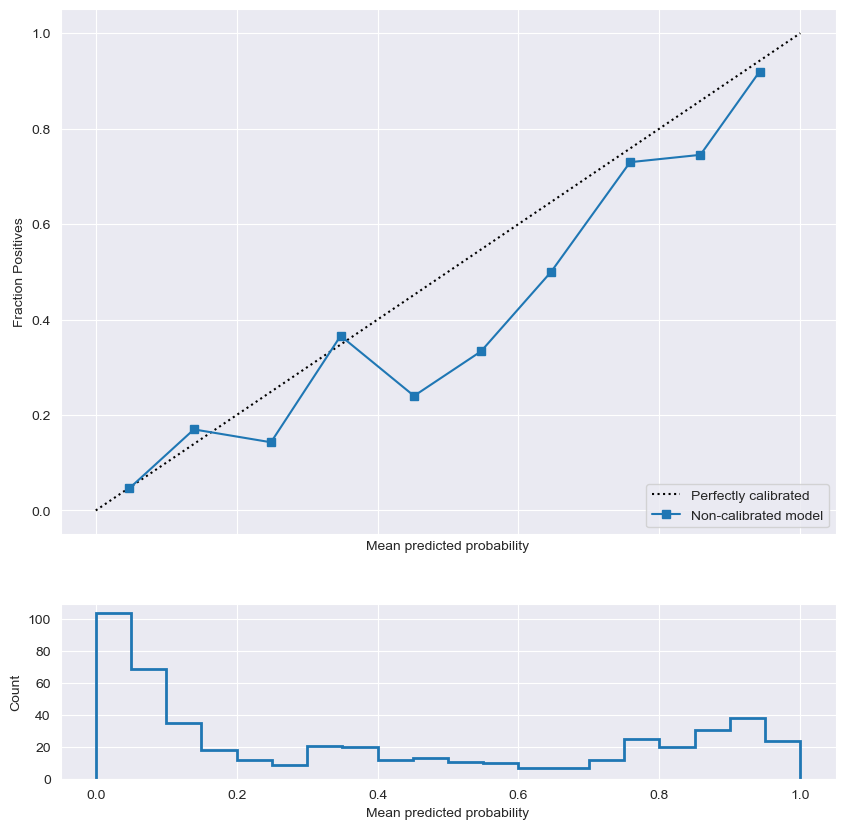

In [233]:
class_0 = (np.array(test_dataset.get_y()) == 0).astype(int)
preds_0 = CM.predict_proba(test_dataset)[:,0]
plot_calib_curve(class_0, preds_0, bins=10)

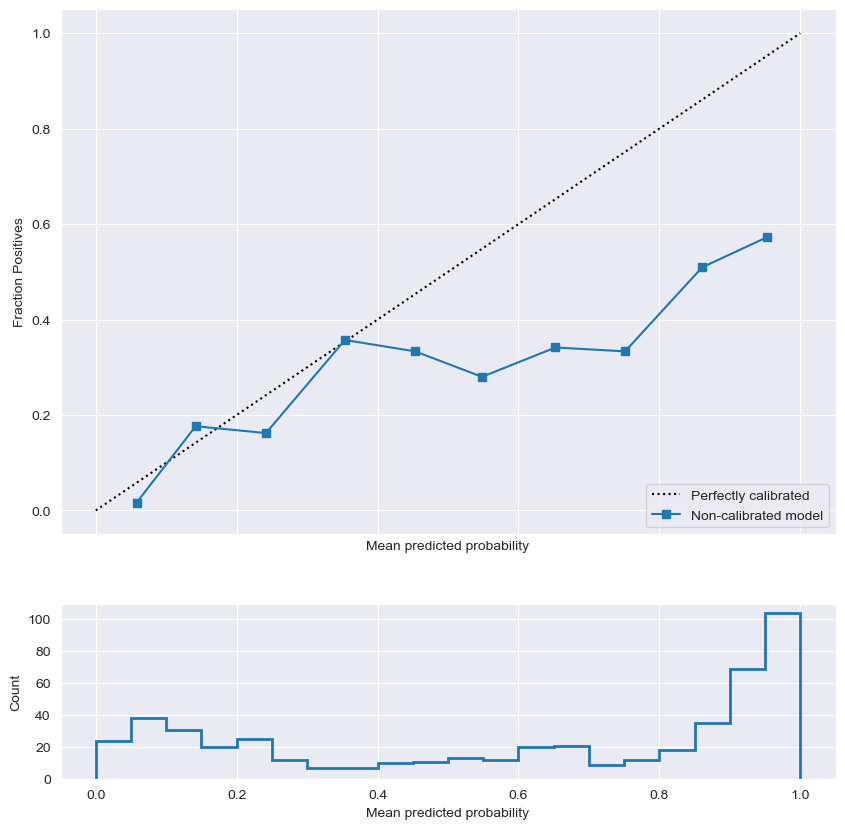

In [232]:
class_2 = (np.array(test_dataset.get_y()) == 2).astype(int)
preds_2 = CM.predict_proba(test_dataset)[:,1]
plot_calib_curve(class_2, preds_2, bins=10)

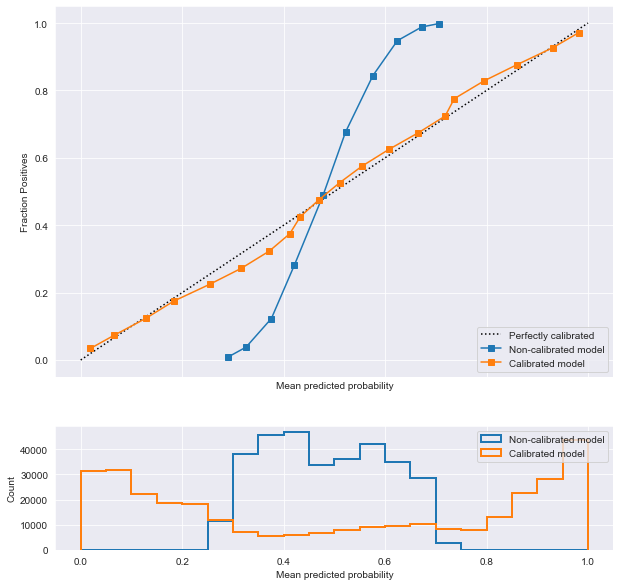

In [6]:
plot_calib_curve(valid_y, preds[:,1], pred_calib[:,1])

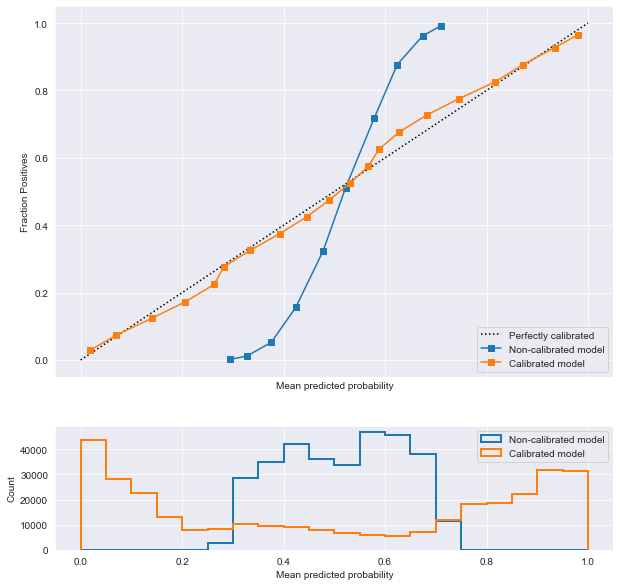

In [7]:
plot_calib_curve((np.array(valid_y) == 0).astype(int), preds[:,0], pred_calib[:,0])

In [4]:
sent140_data = load_dataset("sentiment140")

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/739 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sentiment140 downloaded and prepared to C:\Users\20172613\.cache\huggingface\datasets\sentiment140\sentiment140\1.0.0\f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
np.unique(sent140_data['test']['sentiment'])

array([0, 2, 4])

In [34]:
np.sum(np.array(sent140_data['test']['sentiment']) == 2)/len(sent140_data['test'])

0.2791164658634538

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Import GloVe Embeddings
glove_twitter = GloVe(name="twitter.27B", dim=50)
tweet_data = load_dataset("SetFit/tweet_sentiment_extraction")
tweet_dataset = TweetDataset(split='train', pretrained_vecs=glove_twitter)
# Instantiate vectors and ensure a 0 vector is inserted for unknown characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(2, pre_embeds.shape[1]), pre_embeds))
embedding = nn.Embedding.from_pretrained(pre_embeds, sparse=True, padding_idx=0)


Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
tweet_dataset[88]

(tensor([    1,   195,     6,     1,   357,     3,    12,   427,    47,  3731,
           802,   455,    81,   234, 10786,    18,  1852,   565,     3,    57,
           719,    35,     1,   126,   357,   126,   109,  2297,    16]),
 0)

In [4]:
tk = get_tokenizer("spacy", language="en_core_web_sm")
tk

functools.partial(<function _spacy_tokenize at 0x000001B1EBF49C10>, spacy=<spacy.lang.en.English object at 0x000001B1FF282FA0>)

In [4]:
tweet_dataset.text_pipeline("@sup_dude hello/hi <hashtag>d #hello :-)))")

[2, 998, 40, 591, 73, 4331, 62, 201, 8, 998, 25]

In [18]:
tk("@sup_dude hello/hi <hashtag>d #hello :-)))")

['@sup_dude',
 'hello',
 '/',
 'hi',
 '<',
 'hashtag',
 '>',
 'd',
 '#',
 'hello',
 ':-)))']

In [10]:
tweet_data['train']['text']

[' I`d have responded, if I were going',
 ' Sooo SAD I will miss you here in San Diego!!!',
 'my boss is bullying me...',
 ' what interview! leave me alone',
 ' Sons of ****, why couldn`t they put them on the releases we already bought',
 'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth',
 '2am feedings for the baby are fun when he is all smiles and coos',
 'Soooo high',
 ' Both of you',
 ' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)',
 ' as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff',
 'I really really like the song Love Story by Taylor Swift',
 'My Sharpie is running DANGERously low on ink',
 'i want to go to music tonight but i lost my voice.',
 'test test from the LG enV2',
 'Uh oh, I am sunburned',
 ' S`ok, trying to plot alternatives as we speak *sigh*',
 'i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on i

In [8]:
tk(tweet_data['train']['text'][5])

['http://www.dothebouncy.com/smf',
 '-',
 'some',
 'shameless',
 'plugging',
 'for',
 'the',
 'best',
 'Rangers',
 'forum',
 'on',
 'earth']

In [3]:
glove_twitter = GloVe(name="twitter.27B", dim=50)

# Instantiate vectors and ensure a 0 vector is inserted for unknown characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(1, pre_embeds.shape[1]), pre_embeds))

# Load data:
train_dataset = TweetDataset(split="train", pretrained_vecs=glove_twitter)
valid_dataset = TweetDataset(split="valid", pretrained_vecs=glove_twitter)

# Create data loaders:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
train_dataset[0]

(tensor([3059,  129,  217, 2506]), 1)

In [18]:
next(iter(train_loader))[0][1,:]

tensor([   0, 6516,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [8]:
embedding.weight[998]

tensor([ 0.2875,  0.3132, -0.2932,  0.1720, -0.6923, -0.4593,  1.3364,  0.7090,
         0.1212,  0.1148, -0.4850, -0.0886, -3.0154, -0.5402, -1.3260,  0.3948,
         0.1176, -0.1782, -0.3227,  0.2172,  0.0431, -0.4367, -0.5586, -0.4760,
        -0.0952,  0.0032,  0.1192, -0.2364,  1.3234, -0.4509, -0.6584, -0.1387,
         0.2215, -0.3581,  0.2099,  0.0549, -0.0803,  0.4894,  0.1921,  0.4556,
        -1.6420, -0.8332, -0.1297,  0.9651, -0.1821,  0.3773, -0.1962, -0.1223,
        -0.1050,  0.4539])

In [11]:
tweet_dataset.vocab["<pad>"]
#tweet_dataset.vocab.lookup_token(6516)

0

In [18]:
from sentiment_model.model import SentimentNet
from sentiment_model.data_utils.tweet_dataset import pad_batch

train_loader = DataLoader(tweet_dataset, batch_size=32, shuffle=True, collate_fn=pad_batch)
len(tweet_dataset.vocab)

model = SentimentNet()
model_state_dict = torch.load("checkpoints/cool-bee-4/cool-bee-4-epoch-11.pth")['model_state_dict']
model.load_state_dict(model_state_dict)
data, target, text_lengths = next(iter(train_loader))

In [54]:
tweet_dataset.vocab['Hello']

tz = get_tokenizer("spacy", language="en_core_web_sm")
tweet_dataset.vocab['asfj;lsadj;lasdjf']


RuntimeError: Token asfj;lsadj;lasdjf not found and default index is not set

In [46]:
tz("Helllooo how. lkjadf; are yuou\?")

['Helllooo', 'how', '.', 'lkjadf', ';', 'are', 'yuou\\', '?']

In [74]:
from torchtext. vocab import GloVe, vocab

tokens = tz("Helllooo how. lkjadf; are yuou\?".lower())

glove_twitter = GloVe(name = "twitter.27B", dim=50)

In [101]:
glove_twitter.get_vecs_by_tokens()

tensor([-0.4722,  0.6159, -0.6601, -0.1462, -0.4797, -0.5676,  0.4519,  0.4646,
        -0.2835, -0.6584,  0.3741, -0.6437, -3.3311,  0.3133,  0.2019,  0.1715,
         0.6436,  0.2090,  0.0325, -0.1899, -0.8975,  0.9616, -0.2340, -0.4361,
         0.0687, -0.8583,  0.0737, -0.1705,  0.5671,  0.0952, -0.1938, -0.3952,
         0.1049, -0.2117, -1.0626,  0.4975,  0.0692,  0.2275,  0.0324, -0.6410,
        -0.5017,  0.0518,  0.3308,  0.7859,  1.3322, -0.0709,  0.6726,  0.2338,
        -0.7912, -0.6818])

In [90]:
glove_vocab = vocab(glove_twitter.stoi)
unk_token = "<unk>"
unk_index = 0
glove_vocab.insert_token(unk_token, unk_index)
glove_vocab.set_default_index(unk_index)


1193514

In [99]:
a = torch.tensor([1,2,3])
if a is not None:
    print("Yes")

Yes


In [29]:
tz = BertTokenizer.from_pretrained('bert-base-uncased')
print(tz.ids_to_tokens[0])

[PAD]
